<a href="https://colab.research.google.com/github/kodai-utsunomiya/memorization-and-generalization/blob/main/Grokking_Generalization_Beyond_Overfitting_on_Small_Algorithmic_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/5


Training Progress: 100%|██████████| 4704/4704 [00:06<00:00, 763.03sample/s]


Epoch 1: Training Accuracy = 0.0000, Training Loss = 4.6544, Validation Accuracy = 0.0079, Validation Loss = 4.6311
Epoch 2/5


Training Progress: 100%|██████████| 4704/4704 [00:07<00:00, 667.47sample/s]


Epoch 2: Training Accuracy = 0.0000, Training Loss = 4.5829, Validation Accuracy = 0.0159, Validation Loss = 4.6097
Epoch 3/5


Training Progress: 100%|██████████| 4704/4704 [00:05<00:00, 789.13sample/s]


Epoch 3: Training Accuracy = 0.0312, Training Loss = 4.5363, Validation Accuracy = 0.0125, Validation Loss = 4.5992
Epoch 4/5


Training Progress: 100%|██████████| 4704/4704 [00:07<00:00, 652.65sample/s]


Epoch 4: Training Accuracy = 0.0208, Training Loss = 4.5393, Validation Accuracy = 0.0134, Validation Loss = 4.6072
Epoch 5/5


Training Progress: 100%|██████████| 4704/4704 [00:06<00:00, 755.58sample/s]


Epoch 5: Training Accuracy = 0.0208, Training Loss = 4.5079, Validation Accuracy = 0.0138, Validation Loss = 4.6184


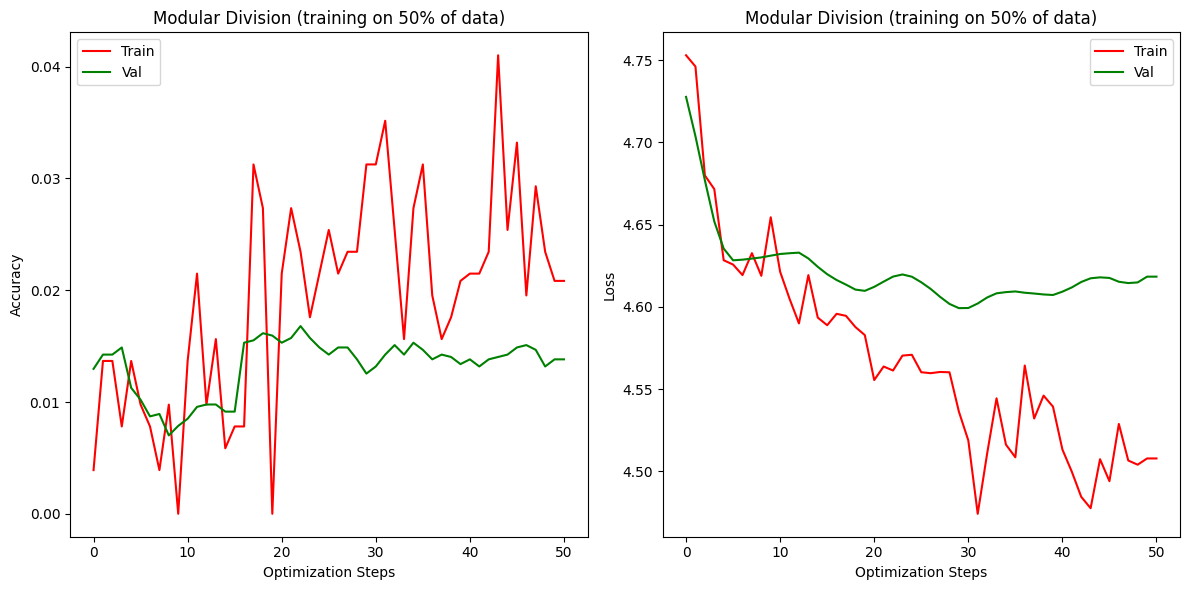

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import Tensor
from einops import rearrange, repeat
from math import ceil
from tqdm import tqdm

# Define operations and data functions
DIVISION_MODULO_OPERATIONS = {
    "x/y": lambda x, y, p: (x * y % p, y, x),
}

ALL_MODULO_OPERATIONS = {
    "x+y": lambda x, y, _: (x, y, x + y),
    "x-y": lambda x, y, _: (x, y, x - y),
    **DIVISION_MODULO_OPERATIONS,
}

ALL_OPERATIONS = {
    **ALL_MODULO_OPERATIONS,
}

def operation_mod_p_data(operation: str, p: int, eq_token: int, op_token: int):
    x = torch.arange(0, p)
    y = torch.arange(0 if operation in DIVISION_MODULO_OPERATIONS else 1, p)
    x, y = torch.cartesian_prod(x, y).T

    eq = torch.ones_like(x) * eq_token
    op = torch.ones_like(x) * op_token

    x, y, labels = ALL_OPERATIONS[operation](x, y, p)

    inputs = torch.stack([x, op, y, eq], dim=1)

    return inputs, labels

def get_data(operation: str, prime: int, training_fraction: float, batch_size: int):
    inputs, labels = operation_mod_p_data(operation, prime, prime, prime+1)
    dataset = TensorDataset(inputs, labels)

    train_size = int(training_fraction * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    batch_size = min(batch_size, ceil(len(dataset) / 2))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader

# Define the model
class DecoderBlock(nn.Module):
    def __init__(self, dim_model: int, n_heads: int):
        super().__init__()

        self.self_attn = nn.MultiheadAttention(dim_model, n_heads)
        self.self_attn_norm = nn.LayerNorm(dim_model)
        self.ffn = nn.Sequential(
            nn.Linear(dim_model, dim_model * 4),
            nn.GELU(),
            nn.Linear(dim_model * 4, dim_model)
        )
        self.ffn_norm = nn.LayerNorm(dim_model)

    def forward(self, x: Tensor):
        attn_mask = torch.full(
            (len(x), len(x)), -float("Inf"), device=x.device, dtype=x.dtype
        )
        attn_mask = torch.triu(attn_mask, diagonal=1)

        a1, _ = self.self_attn(x, x, x, attn_mask=attn_mask)
        a1 = self.self_attn_norm(x + a1)
        a2 = self.ffn(a1)
        a2 = self.ffn_norm(a1 + a2)

        return a2

class Transformer(nn.Module):
    def __init__(self, num_layers: int, dim_model: int, num_heads: int, num_tokens: int, seq_len: int):
        super().__init__()

        self.token_embeddings = nn.Embedding(num_tokens, dim_model)
        self.position_embeddings = nn.Embedding(seq_len, dim_model)
        self.model = nn.Sequential(
            *[DecoderBlock(dim_model, num_heads) for _ in range(num_layers)],
            nn.LayerNorm(dim_model),
            nn.Linear(dim_model, num_tokens)
        )

    def forward(self, inputs: Tensor):
        batch_size, context_len = inputs.shape

        token_embedding = self.token_embeddings(inputs)

        positions = repeat(torch.arange(context_len, device=inputs.device), "p -> b p", b=batch_size)
        position_embedding = self.position_embeddings(positions)

        embedding = token_embedding + position_embedding

        embedding = rearrange(embedding, 'b s d -> s b d')

        return self.model(embedding)

# Training and evaluation functions
def evaluate(model, data_loader, device, metrics, step=None):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    correct = 0
    total_loss = 0.0
    with torch.no_grad():
        for batch in data_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch
            output = model(inputs)[-1, :, :]
            correct += (torch.argmax(output, dim=1) == labels).sum().item()
            total_loss += criterion(output, labels).item() * len(labels)

    accuracy = correct / len(data_loader.dataset)
    loss = total_loss / len(data_loader.dataset)

    if step is not None:
        metrics['validation/accuracy'].append((step, accuracy))
        metrics['validation/loss'].append((step, loss))
    else:
        metrics['validation/accuracy'].append(accuracy)
        metrics['validation/loss'].append(loss)

    return metrics

def train(model, train_loader, optimizer, scheduler, val_loader, device, metrics, step, record_frequency):
    model.train()
    criterion = nn.CrossEntropyLoss()

    # Initialize tqdm progress bar only once
    pbar = tqdm(total=len(train_loader.dataset), desc="Training Progress", unit='sample')

    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs, labels = batch

        optimizer.zero_grad()
        output = model(inputs)[-1, :, :]
        loss = criterion(output, labels)
        acc = (torch.argmax(output, dim=1) == labels).sum().item() / len(labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Update metrics at the end of each batch
        if step % record_frequency == 0:
            metrics['training/accuracy'].append((step, acc))
            metrics['training/loss'].append((step, loss.item()))

        # Update progress bar with the batch size
        pbar.update(inputs.size(0))

        # Evaluate validation set every `record_frequency` steps
        if step % record_frequency == 0:
            metrics = evaluate(model, val_loader, device, metrics, step)

        step += 1

    pbar.close()

    return metrics, step

def main():
    # Configuration
    config = {
        'operation': 'x/y',
        'training_fraction': 0.5,
        'prime': 97,
        'num_layers': 2,
        'dim_model': 128,
        'num_heads': 4,
        'batch_size': 512,
        'learning_rate': 1e-3,
        'weight_decay': 1,
        'num_steps': int(1e5),
        'max_epochs': 5,
        'record_frequency': 10,  # Frequency of recording metrics
        'device': 'cpu',
    }

    device = torch.device(config['device'])
    train_loader, val_loader = get_data(
        config['operation'],
        config['prime'],
        config['training_fraction'],
        config['batch_size']
    )
    model = Transformer(
        num_layers=config['num_layers'],
        dim_model=config['dim_model'],
        num_heads=config['num_heads'],
        num_tokens=config['prime'] + 2,
        seq_len=5
    ).to(device)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        betas=(0.9, 0.98),
        weight_decay=config['weight_decay']
    )
    scheduler = optim.lr_scheduler.LinearLR(
        optimizer, start_factor=0.1, total_iters=9
    )

    num_epochs = min(config['max_epochs'], ceil(config['num_steps'] / len(train_loader)))

    metrics = {
        'training/accuracy': [],
        'training/loss': [],
        'validation/accuracy': [],
        'validation/loss': []
    }

    stable_steps = 0
    max_stable_steps = 100

    step = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        metrics, step = train(model, train_loader, optimizer, scheduler, val_loader, device, metrics, step, config['record_frequency'])

        # Print metrics for the current epoch in a single line
        train_acc = metrics['training/accuracy'][-1][1]
        train_loss = metrics['training/loss'][-1][1]
        val_acc = metrics['validation/accuracy'][-1][1] if len(metrics['validation/accuracy']) > 0 else 0
        val_loss = metrics['validation/loss'][-1][1] if len(metrics['validation/loss']) > 0 else 0

        print(f"Epoch {epoch + 1}: Training Accuracy = {train_acc:.4f}, Training Loss = {train_loss:.4f}, Validation Accuracy = {val_acc:.4f}, Validation Loss = {val_loss:.4f}")

        # Check validation accuracy
        if val_acc >= 0.99:
            stable_steps += 1
            print(f"Stable Steps: {stable_steps}/{max_stable_steps}")
        else:
            stable_steps = 0

        if stable_steps >= max_stable_steps:
            print("Stopping early as validation accuracy has been >= 99% for 100 consecutive steps.")
            break

    # Ensure the final step is evaluated for training metrics
    metrics['training/accuracy'].append((step, train_acc))
    metrics['training/loss'].append((step, train_loss))
    metrics = evaluate(model, val_loader, device, metrics, step)

    # Plot metrics
    training_steps, training_accuracy = zip(*metrics['training/accuracy'])
    training_steps, training_loss = zip(*metrics['training/loss'])
    val_steps, validation_accuracy = zip(*metrics['validation/accuracy'])
    val_steps, validation_loss = zip(*metrics['validation/loss'])

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(training_steps, training_accuracy, color='red', label='Train')
    plt.plot(val_steps, validation_accuracy, color='green', label='Val')
    plt.xlabel('Optimization Steps')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Modular Division (training on {int(config["training_fraction"] * 100)}% of data)')

    plt.subplot(1, 2, 2)
    plt.plot(training_steps, training_loss, color='red', label='Train')
    plt.plot(val_steps, validation_loss, color='green', label='Val')
    plt.xlabel('Optimization Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Modular Division (training on {int(config["training_fraction"] * 100)}% of data)')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Epoch 1/5


Training Progress: 100%|██████████| 4704/4704 [00:04<00:00, 1049.29sample/s]


Epoch 1: Training Accuracy = 0.0020, Training Loss = 4.8404, Validation Accuracy = 0.0094, Validation Loss = 4.7723
Epoch 2/5


Training Progress: 100%|██████████| 4704/4704 [00:01<00:00, 2600.05sample/s]


Epoch 2: Training Accuracy = 0.0098, Training Loss = 4.6093, Validation Accuracy = 0.0079, Validation Loss = 4.6435
Epoch 3/5


Training Progress: 100%|██████████| 4704/4704 [00:01<00:00, 2644.73sample/s]


Epoch 3: Training Accuracy = 0.0117, Training Loss = 4.5946, Validation Accuracy = 0.0174, Validation Loss = 4.6107
Epoch 4/5


Training Progress: 100%|██████████| 4704/4704 [00:01<00:00, 2630.89sample/s]


Epoch 4: Training Accuracy = 0.0137, Training Loss = 4.5682, Validation Accuracy = 0.0172, Validation Loss = 4.5989
Epoch 5/5


Training Progress: 100%|██████████| 4704/4704 [00:01<00:00, 2654.79sample/s]


Epoch 5: Training Accuracy = 0.0273, Training Loss = 4.5302, Validation Accuracy = 0.0162, Validation Loss = 4.5974


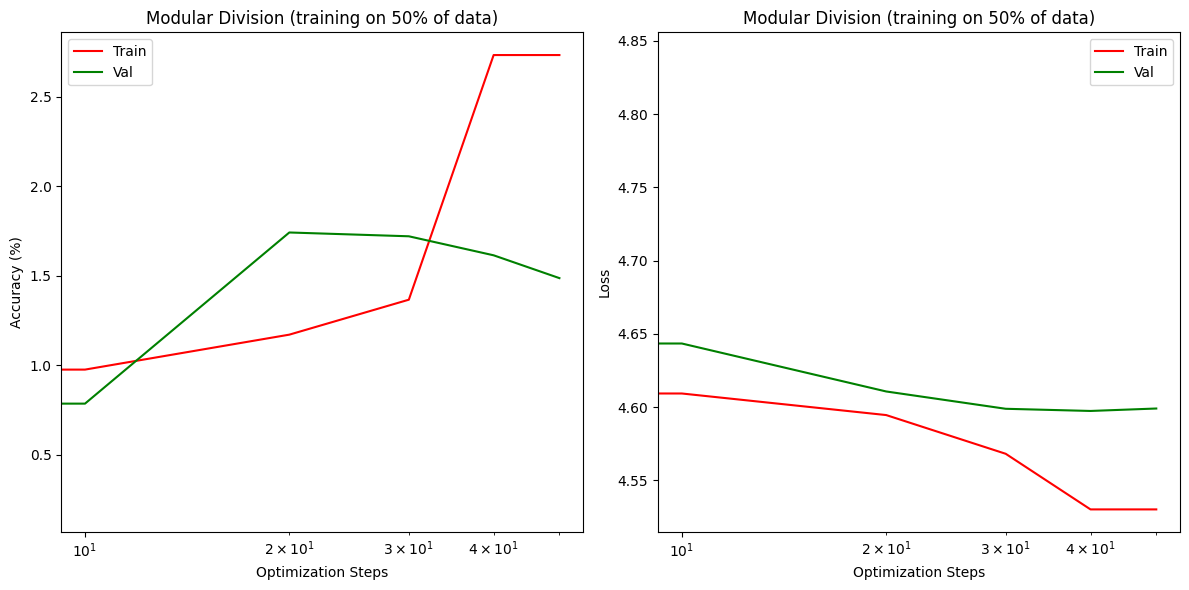

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import Tensor
from einops import rearrange, repeat
from math import ceil
from tqdm import tqdm

# Define operations and data functions
DIVISION_MODULO_OPERATIONS = {
    "x/y": lambda x, y, p: (x * y % p, y, x),
}

ALL_MODULO_OPERATIONS = {
    "x+y": lambda x, y, _: (x, y, x + y),
    "x-y": lambda x, y, _: (x, y, x - y),
    **DIVISION_MODULO_OPERATIONS,
}

ALL_OPERATIONS = {
    **ALL_MODULO_OPERATIONS,
}

def operation_mod_p_data(operation: str, p: int, eq_token: int, op_token: int):
    x = torch.arange(0, p)
    y = torch.arange(0 if operation in DIVISION_MODULO_OPERATIONS else 1, p)
    x, y = torch.cartesian_prod(x, y).T

    eq = torch.ones_like(x) * eq_token
    op = torch.ones_like(x) * op_token

    x, y, labels = ALL_OPERATIONS[operation](x, y, p)

    inputs = torch.stack([x, op, y, eq], dim=1)

    return inputs, labels

def get_data(operation: str, prime: int, training_fraction: float, batch_size: int):
    inputs, labels = operation_mod_p_data(operation, prime, prime, prime+1)
    dataset = TensorDataset(inputs, labels)

    train_size = int(training_fraction * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    batch_size = min(batch_size, ceil(len(dataset) / 2))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader

# Define the model
class DecoderBlock(nn.Module):
    def __init__(self, dim_model: int, n_heads: int):
        super().__init__()

        self.self_attn = nn.MultiheadAttention(dim_model, n_heads)
        self.self_attn_norm = nn.LayerNorm(dim_model)
        self.ffn = nn.Sequential(
            nn.Linear(dim_model, dim_model * 4),
            nn.GELU(),
            nn.Linear(dim_model * 4, dim_model)
        )
        self.ffn_norm = nn.LayerNorm(dim_model)

    def forward(self, x: Tensor):
        attn_mask = torch.full(
            (len(x), len(x)), -float("Inf"), device=x.device, dtype=x.dtype
        )
        attn_mask = torch.triu(attn_mask, diagonal=1)

        a1, _ = self.self_attn(x, x, x, attn_mask=attn_mask)
        a1 = self.self_attn_norm(x + a1)
        a2 = self.ffn(a1)
        a2 = self.ffn_norm(a1 + a2)

        return a2

class Transformer(nn.Module):
    def __init__(self, num_layers: int, dim_model: int, num_heads: int, num_tokens: int, seq_len: int):
        super().__init__()

        self.token_embeddings = nn.Embedding(num_tokens, dim_model)
        self.position_embeddings = nn.Embedding(seq_len, dim_model)
        self.model = nn.Sequential(
            *[DecoderBlock(dim_model, num_heads) for _ in range(num_layers)],
            nn.LayerNorm(dim_model),
            nn.Linear(dim_model, num_tokens)
        )

    def forward(self, inputs: Tensor):
        batch_size, context_len = inputs.shape

        token_embedding = self.token_embeddings(inputs)

        positions = repeat(torch.arange(context_len, device=inputs.device), "p -> b p", b=batch_size)
        position_embedding = self.position_embeddings(positions)

        embedding = token_embedding + position_embedding

        embedding = rearrange(embedding, 'b s d -> s b d')

        return self.model(embedding)

# Training and evaluation functions
def evaluate(model, data_loader, device, metrics, step=None):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    correct = 0
    total_loss = 0.0
    with torch.no_grad():
        for batch in data_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch
            output = model(inputs)[-1, :, :]
            correct += (torch.argmax(output, dim=1) == labels).sum().item()
            total_loss += criterion(output, labels).item() * len(labels)

    accuracy = correct / len(data_loader.dataset)
    loss = total_loss / len(data_loader.dataset)

    if step is not None:
        metrics['validation/accuracy'].append((step, accuracy))
        metrics['validation/loss'].append((step, loss))
    else:
        metrics['validation/accuracy'].append(accuracy)
        metrics['validation/loss'].append(loss)

    return metrics

def train(model, train_loader, optimizer, scheduler, val_loader, device, metrics, step, record_frequency):
    model.train()
    criterion = nn.CrossEntropyLoss()

    pbar = tqdm(total=len(train_loader.dataset), desc="Training Progress", unit='sample')

    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs, labels = batch

        optimizer.zero_grad()
        output = model(inputs)[-1, :, :]
        loss = criterion(output, labels)
        acc = (torch.argmax(output, dim=1) == labels).sum().item() / len(labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Update metrics at the end of each batch
        if step % record_frequency == 0:
            metrics['training/accuracy'].append((step, acc))
            metrics['training/loss'].append((step, loss.item()))

        pbar.update(inputs.size(0))

        # Evaluate validation set every `record_frequency` steps
        if step % record_frequency == 0:
            metrics = evaluate(model, val_loader, device, metrics, step)

        step += 1

    pbar.close()

    return metrics, step

def main():
    # Configuration
    config = {
        'operation': 'x/y',
        'training_fraction': 0.5,
        'prime': 97,
        'num_layers': 2,
        'dim_model': 128,
        'num_heads': 4,
        'batch_size': 512,
        'learning_rate': 1e-3,
        'weight_decay': 1,
        'num_steps': int(1e5),
        'max_epochs': 5,
        'record_frequency': 10,  # Frequency of recording metrics
        'device': 'cpu',
    }

    device = torch.device(config['device'])
    train_loader, val_loader = get_data(
        config['operation'],
        config['prime'],
        config['training_fraction'],
        config['batch_size']
    )
    model = Transformer(
        num_layers=config['num_layers'],
        dim_model=config['dim_model'],
        num_heads=config['num_heads'],
        num_tokens=config['prime'] + 2,
        seq_len=5
    ).to(device)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        betas=(0.9, 0.98),
        weight_decay=config['weight_decay']
    )
    scheduler = optim.lr_scheduler.LinearLR(
        optimizer, start_factor=0.1, total_iters=9
    )

    num_epochs = min(config['max_epochs'], ceil(config['num_steps'] / len(train_loader)))

    metrics = {
        'training/accuracy': [],
        'training/loss': [],
        'validation/accuracy': [],
        'validation/loss': []
    }

    stable_steps = 0
    max_stable_steps = 100

    step = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        metrics, step = train(model, train_loader, optimizer, scheduler, val_loader, device, metrics, step, config['record_frequency'])

        # Print metrics for the current epoch in a single line
        train_acc = metrics['training/accuracy'][-1][1]
        train_loss = metrics['training/loss'][-1][1]
        val_acc = metrics['validation/accuracy'][-1][1] if len(metrics['validation/accuracy']) > 0 else 0
        val_loss = metrics['validation/loss'][-1][1] if len(metrics['validation/loss']) > 0 else 0

        print(f"Epoch {epoch + 1}: Training Accuracy = {train_acc:.4f}, Training Loss = {train_loss:.4f}, Validation Accuracy = {val_acc:.4f}, Validation Loss = {val_loss:.4f}")

        # Check validation accuracy
        if val_acc >= 0.99:
            stable_steps += 1
            print(f"Stable Steps: {stable_steps}/{max_stable_steps}")
        else:
            stable_steps = 0

        if stable_steps >= max_stable_steps:
            print("Stopping early as validation accuracy has been >= 99% for 100 consecutive steps.")
            break

    # Ensure the final step is evaluated for training metrics
    metrics['training/accuracy'].append((step, train_acc))
    metrics['training/loss'].append((step, train_loss))
    metrics = evaluate(model, val_loader, device, metrics, step)

    # Plot metrics
    training_steps, training_accuracy = zip(*metrics['training/accuracy'])
    training_steps, training_loss = zip(*metrics['training/loss'])
    val_steps, validation_accuracy = zip(*metrics['validation/accuracy'])
    val_steps, validation_loss = zip(*metrics['validation/loss'])

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.semilogx(training_steps, [acc * 100 for acc in training_accuracy], color='red', label='Train')
    plt.semilogx(val_steps, [acc * 100 for acc in validation_accuracy], color='green', label='Val')
    plt.xlabel('Optimization Steps')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title(f'Modular Division (training on {int(config["training_fraction"] * 100)}% of data)')

    plt.subplot(1, 2, 2)
    plt.semilogx(training_steps, training_loss, color='red', label='Train')
    plt.semilogx(val_steps, validation_loss, color='green', label='Val')
    plt.xlabel('Optimization Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Modular Division (training on {int(config["training_fraction"] * 100)}% of data)')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import Tensor
from einops import rearrange, repeat
from math import ceil
from tqdm import tqdm

# Define operations and data functions
DIVISION_MODULO_OPERATIONS = {
    "x/y": lambda x, y, p: (x * y % p, y, x),
}

ALL_MODULO_OPERATIONS = {
    "x+y": lambda x, y, _: (x, y, x + y),
    "x-y": lambda x, y, _: (x, y, x - y),
    **DIVISION_MODULO_OPERATIONS,
}

ALL_OPERATIONS = {
    **ALL_MODULO_OPERATIONS,
}

def operation_mod_p_data(operation: str, p: int, eq_token: int, op_token: int):
    x = torch.arange(0, p)
    y = torch.arange(0 if operation in DIVISION_MODULO_OPERATIONS else 1, p)
    x, y = torch.cartesian_prod(x, y).T

    eq = torch.ones_like(x) * eq_token
    op = torch.ones_like(x) * op_token

    x, y, labels = ALL_OPERATIONS[operation](x, y, p)

    inputs = torch.stack([x, op, y, eq], dim=1)

    return inputs, labels

def get_data(operation: str, prime: int, training_fraction: float, batch_size: int):
    inputs, labels = operation_mod_p_data(operation, prime, prime, prime+1)
    dataset = TensorDataset(inputs, labels)

    train_size = int(training_fraction * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    batch_size = min(batch_size, ceil(len(dataset) / 2))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader

# Define the model
class DecoderBlock(nn.Module):
    def __init__(self, dim_model: int, n_heads: int):
        super().__init__()

        self.self_attn = nn.MultiheadAttention(dim_model, n_heads)
        self.self_attn_norm = nn.LayerNorm(dim_model)
        self.ffn = nn.Sequential(
            nn.Linear(dim_model, dim_model * 4),
            nn.GELU(),
            nn.Linear(dim_model * 4, dim_model)
        )
        self.ffn_norm = nn.LayerNorm(dim_model)

    def forward(self, x: Tensor):
        attn_mask = torch.full(
            (len(x), len(x)), -float("Inf"), device=x.device, dtype=x.dtype
        )
        attn_mask = torch.triu(attn_mask, diagonal=1)

        a1, _ = self.self_attn(x, x, x, attn_mask=attn_mask)
        a1 = self.self_attn_norm(x + a1)
        a2 = self.ffn(a1)
        a2 = self.ffn_norm(a1 + a2)

        return a2

class Transformer(nn.Module):
    def __init__(self, num_layers: int, dim_model: int, num_heads: int, num_tokens: int, seq_len: int):
        super().__init__()

        self.token_embeddings = nn.Embedding(num_tokens, dim_model)
        self.position_embeddings = nn.Embedding(seq_len, dim_model)
        self.model = nn.Sequential(
            *[DecoderBlock(dim_model, num_heads) for _ in range(num_layers)],
            nn.LayerNorm(dim_model),
            nn.Linear(dim_model, num_tokens)
        )

    def forward(self, inputs: Tensor):
        batch_size, context_len = inputs.shape

        token_embedding = self.token_embeddings(inputs)

        positions = repeat(torch.arange(context_len, device=inputs.device), "p -> b p", b=batch_size)
        position_embedding = self.position_embeddings(positions)

        embedding = token_embedding + position_embedding

        embedding = rearrange(embedding, 'b s d -> s b d')

        return self.model(embedding)

# Training and evaluation functions
def evaluate(model, data_loader, device, metrics, step=None):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    correct = 0
    total_loss = 0.0
    with torch.no_grad():
        for batch in data_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch
            output = model(inputs)[-1, :, :]
            correct += (torch.argmax(output, dim=1) == labels).sum().item()
            total_loss += criterion(output, labels).item() * len(labels)

    accuracy = correct / len(data_loader.dataset)
    loss = total_loss / len(data_loader.dataset)

    if step is not None:
        metrics['validation/accuracy'].append((step, accuracy))
        metrics['validation/loss'].append((step, loss))
    else:
        metrics['validation/accuracy'].append(accuracy)
        metrics['validation/loss'].append(loss)

    return metrics

def train(model, train_loader, optimizer, scheduler, val_loader, device, metrics, step, record_frequency, num_steps):
    model.train()
    criterion = nn.CrossEntropyLoss()

    pbar = tqdm(total=num_steps, desc="Training Progress", unit='step')

    while step < num_steps:
        for batch in train_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch

            optimizer.zero_grad()
            output = model(inputs)[-1, :, :]
            loss = criterion(output, labels)
            acc = (torch.argmax(output, dim=1) == labels).sum().item() / len(labels)

            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update metrics at the end of each batch
            if step % record_frequency == 0:
                metrics['training/accuracy'].append((step, acc))
                metrics['training/loss'].append((step, loss.item()))

            pbar.update(1)  # Update progress bar for each step

            # Evaluate validation set every `record_frequency` steps
            if step % record_frequency == 0:
                metrics = evaluate(model, val_loader, device, metrics, step)

            step += 1
            if step >= num_steps:
                break

    pbar.close()

    return metrics, step

def main():
    # Configuration
    config = {
        'operation': 'x/y',
        'training_fraction': 0.5,
        'prime': 97,
        'num_layers': 2,
        'dim_model': 128,
        'num_heads': 4,
        'batch_size': 512,
        'learning_rate': 1e-3,
        'weight_decay': 1,
        'num_steps': int(1e5),
        'record_frequency': 10,  # Frequency of recording metrics
        'device': 'cpu',
    }

    device = torch.device(config['device'])
    train_loader, val_loader = get_data(
        config['operation'],
        config['prime'],
        config['training_fraction'],
        config['batch_size']
    )
    model = Transformer(
        num_layers=config['num_layers'],
        dim_model=config['dim_model'],
        num_heads=config['num_heads'],
        num_tokens=config['prime'] + 2,
        seq_len=5
    ).to(device)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        betas=(0.9, 0.98),
        weight_decay=config['weight_decay']
    )
    scheduler = optim.lr_scheduler.LinearLR(
        optimizer, start_factor=0.1, total_iters=9
    )

    num_steps = config['num_steps']
    num_epochs = ceil(num_steps / len(train_loader))  # Calculate number of epochs based on num_steps

    metrics = {
        'training/accuracy': [],
        'training/loss': [],
        'validation/accuracy': [],
        'validation/loss': []
    }

    step = 0
    stable_steps = 0
    max_stable_steps = 100

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        metrics, step = train(model, train_loader, optimizer, scheduler, val_loader, device, metrics, step, config['record_frequency'], num_steps)

        # Print metrics for the current epoch in a single line
        train_acc = metrics['training/accuracy'][-1][1] if metrics['training/accuracy'] else 0
        train_loss = metrics['training/loss'][-1][1] if metrics['training/loss'] else 0
        val_acc = metrics['validation/accuracy'][-1][1] if len(metrics['validation/accuracy']) > 0 else 0
        val_loss = metrics['validation/loss'][-1][1] if len(metrics['validation/loss']) > 0 else 0

        print(f"Epoch {epoch + 1}: Training Accuracy = {train_acc:.4f}, Training Loss = {train_loss:.4f}, Validation Accuracy = {val_acc:.4f}, Validation Loss = {val_loss:.4f}")

        # Check validation accuracy
        if val_acc >= 0.99:
            stable_steps += 1
            print(f"Stable Steps: {stable_steps}/{max_stable_steps}")
        else:
            stable_steps = 0

        if stable_steps >= max_stable_steps:
            print("Stopping early as validation accuracy has been >= 99% for 100 consecutive steps.")
            break

    # Ensure the final step is evaluated for training metrics
    metrics['training/accuracy'].append((step, train_acc))
    metrics['training/loss'].append((step, train_loss))
    metrics = evaluate(model, val_loader, device, metrics, step)

    # Plot metrics
    training_steps, training_accuracy = zip(*metrics['training/accuracy'])
    training_steps, training_loss = zip(*metrics['training/loss'])
    val_steps, validation_accuracy = zip(*metrics['validation/accuracy'])
    val_steps, validation_loss = zip(*metrics['validation/loss'])

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.semilogx(training_steps, [acc * 100 for acc in training_accuracy], color='red', label='Train')
    plt.semilogx(val_steps, [acc * 100 for acc in validation_accuracy], color='green', label='Val')
    plt.xlabel('Optimization Steps')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title(f'Modular Division (training on {int(config["training_fraction"] * 100)}% of data)')

    plt.subplot(1, 2, 2)
    plt.semilogx(training_steps, training_loss, color='red', label='Train')
    plt.semilogx(val_steps, validation_loss, color='green', label='Val')
    plt.xlabel('Optimization Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Modular Division (training on {int(config["training_fraction"] * 100)}% of data)')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Epoch 1/10000


Training Progress:   0%|          | 11/100000 [00:07<12:11:58,  2.28step/s]

KeyboardInterrupt: 